In [8]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [10]:
w, h = 304,304
border = 5 

In [11]:
ids = next(os.walk("/content/800_dataset_with_semantic_segmentation/train_images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  61


# **Data Reading and Train test split**

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import glob
train = sorted(glob.glob("/content/800_dataset_with_semantic_segmentation/train_images/*"))
train_mask = sorted(glob.glob("/content/800_dataset_with_semantic_segmentation/train_segmentation/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 61
Total Mask Image : 61


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

In [13]:
# Save the files in Numpy array for reusability
np.save('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/X.npy', X)
np.save('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/y.npy', y)
print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/X.npy')
y = np.load('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/y.npy')
print(X.shape, y.shape)

(61, 304, 304, 3) (61, 304, 304, 1)


In [14]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(54, 304, 304, 3) (54, 304, 304, 1) (7, 304, 304, 3) (7, 304, 304, 1)


14

# **Visualization the image and It masks**

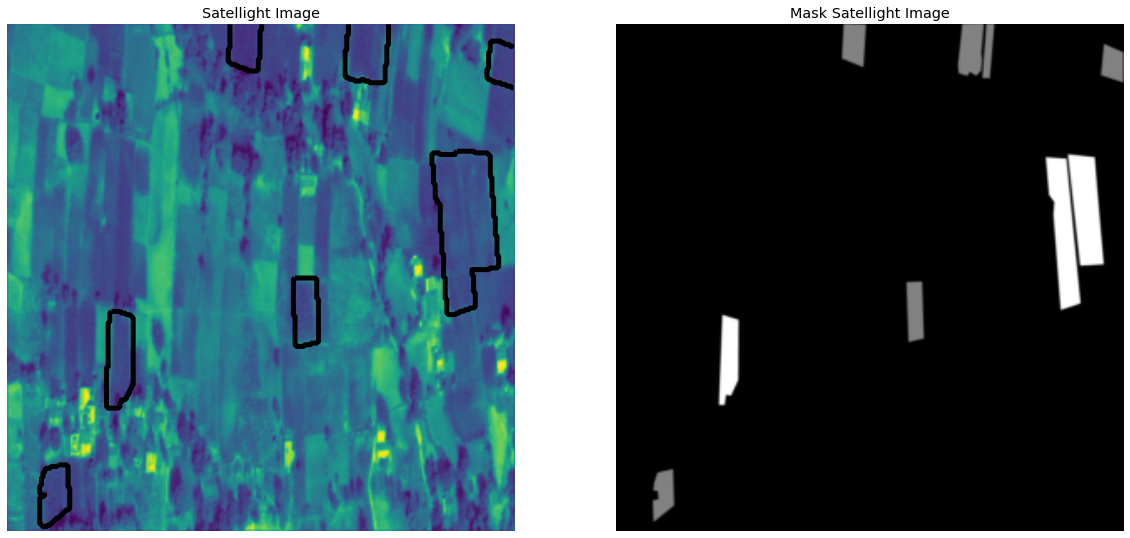

In [15]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

### DenseUnet

In [23]:
def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def DenseUNet(image_size=304):

    filters=16
    keep_prob=0.9
    block_size=7

    inputs = Input(shape=(image_size, image_size, 3))

    conv1 = Conv2D(filters * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(filters * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(filters * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(filters * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = DenseBlock(filters * 8, pool3)

    deconv3 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(filters * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(filters * 4, uconv3)


    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(filters * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(filters * 2, uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(filters * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(filters * 1, uconv1)

    outputs = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [24]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 3), name='img')
model = DenseUNet(image_size = 304)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304, 304, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 304, 304, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 304, 304, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 304, 304, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [28]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-DenseUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataDenseUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [29]:
results = model.fit(X_train, y_train, batch_size=6, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True, workers=31)

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.9404 - auc: 0.4519 - sensitivity_at_specificity: 0.3970 - specificity_at_sensitivity: 0.4123
Epoch 00001: val_loss improved from inf to 0.61317, saving model to model-DenseUnet.h5
9/9 [==============================] - 4s 390ms/step - loss: 0.4221 - accuracy: 0.9404 - auc: 0.4519 - sensitivity_at_specificity: 0.3970 - specificity_at_sensitivity: 0.4123 - val_loss: 0.6132 - val_accuracy: 0.9735 - val_auc: 0.4535 - val_sensitivity_at_specificity: 0.2818 - val_specificity_at_sensitivity: 0.3519
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.9605 - auc: 0.4140 - sensitivity_at_specificity: 0.3561 - specificity_at_sensitivity: 0.3365
Epoch 00002: val_loss improved from 0.61317 to 0.56349, saving model to model-DenseUnet.h5
9/9 [==============================] - 3s 358ms/step - loss: 0.3230 - accuracy: 0.9605 - auc: 0.4140 - sensitivity_at_specificity: 0.3561 - specifi

In [30]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
4,0.189317,0.965154,0.487581,0.424221,0.470276,0.367451,0.978397,0.359910,0.277567,0.286755,0.001
3,0.219247,0.964462,0.463833,0.393047,0.390251,0.428975,0.978397,0.411906,0.369374,0.400185,0.001
2,0.262121,0.962179,0.430462,0.336443,0.351005,0.485156,0.978397,0.474187,0.507764,0.504824,0.001
1,0.323043,0.960480,0.413955,0.356106,0.336486,0.563494,0.977890,0.411330,0.243220,0.407415,0.001
0,0.422137,0.940419,0.451851,0.396981,0.412332,0.613167,0.973522,0.453458,0.281789,0.351901,0.001


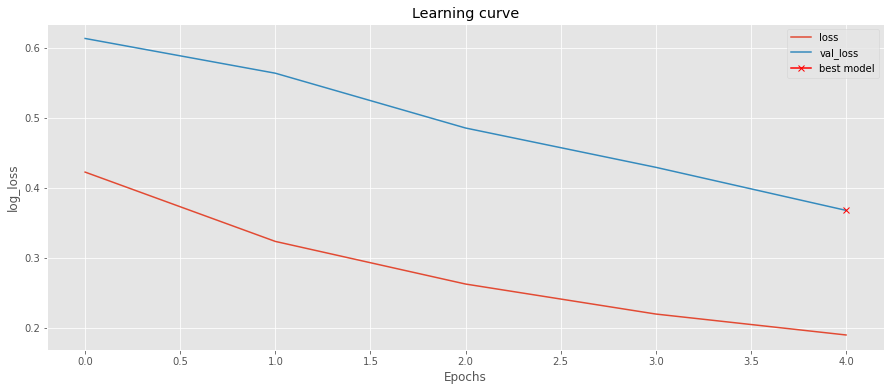

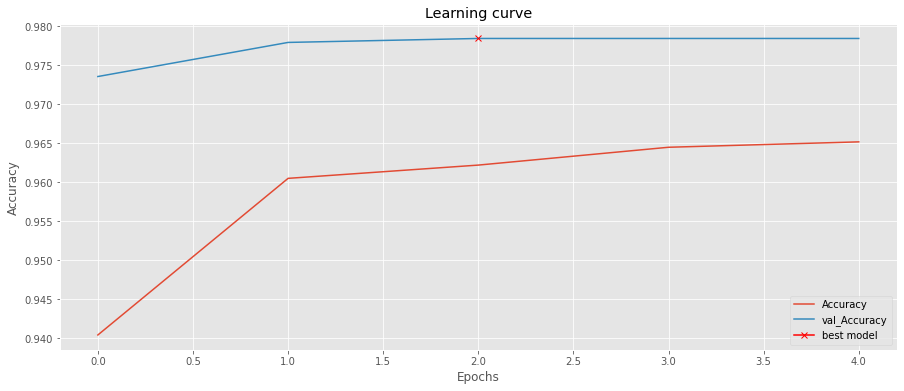

In [31]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [33]:
model.load_weights('model-DenseUnet.h5')

In [34]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.9784 - auc: 0.3599 - sensitivity_at_specificity: 0.2776 - specificity_at_sensitivity: 0.2868


[0.36745065450668335,
 0.9783973693847656,
 0.3599106967449188,
 0.2775670886039734,
 0.28675681352615356]

In [35]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 56ms/step


In [36]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [44]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

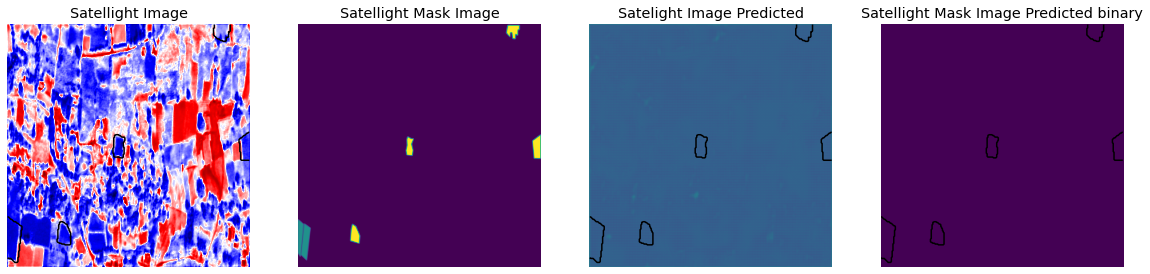

In [45]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

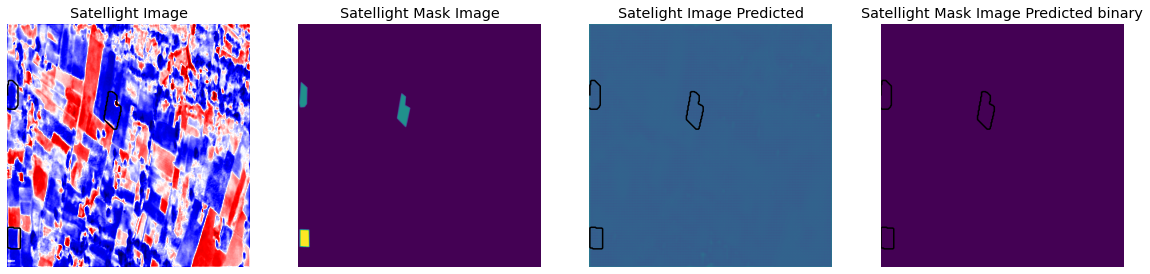

In [39]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

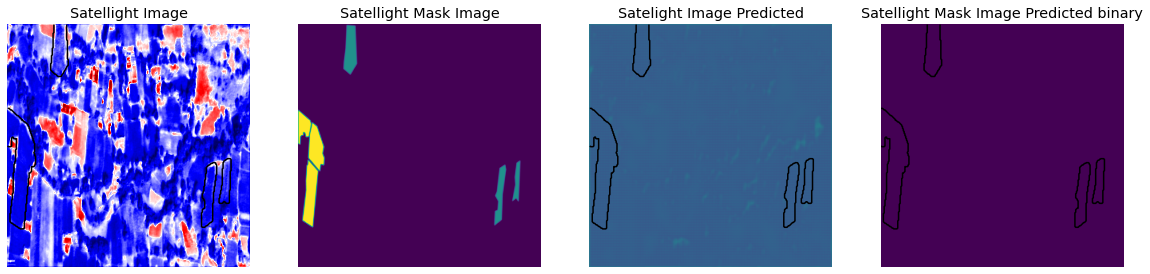

In [40]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

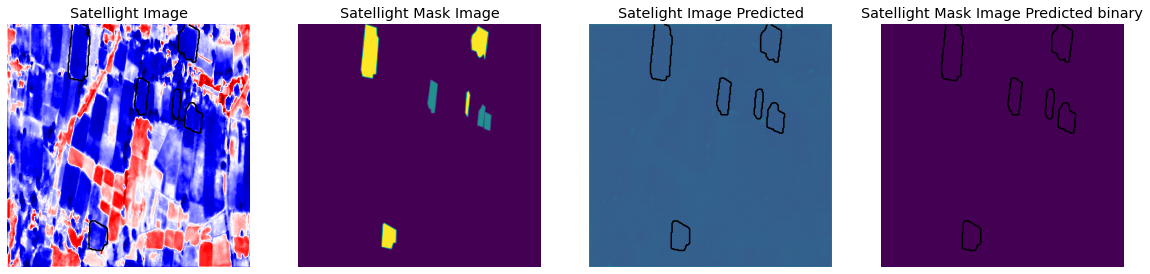

In [41]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

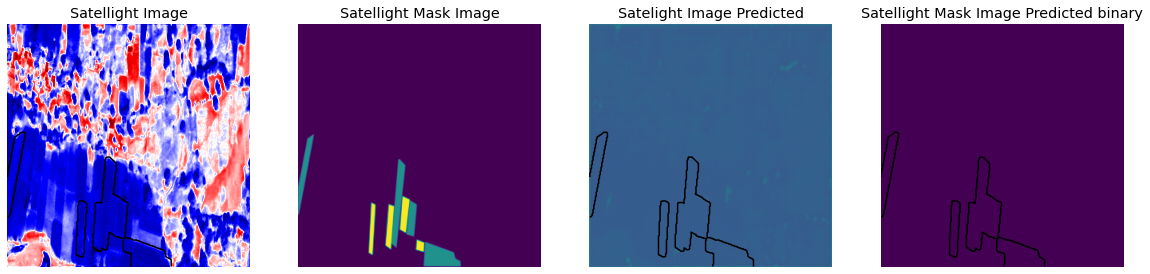

In [42]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

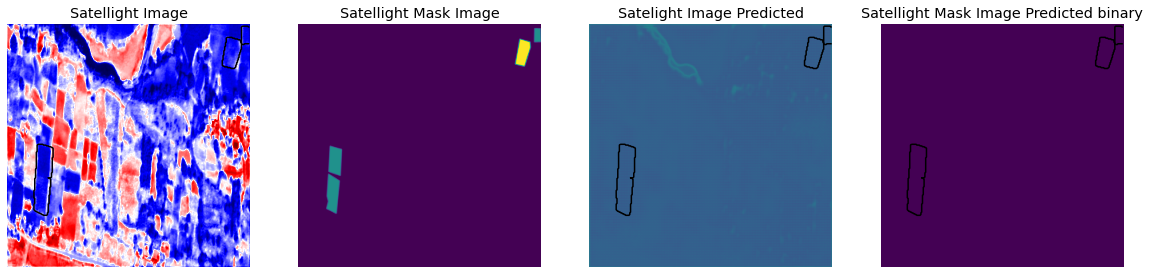

In [43]:
plot_sample(X_train, y_train, preds_train, preds_train_t)